In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from eofs.xarray import Eof

# -----------------------------
# 1. Load dataset
# -----------------------------
ds = xr.open_dataset("/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc")
thetao = ds['thetao']

# -----------------------------
# 2. Select surface layer (uppermost depth)
# -----------------------------
thetao_surf = thetao.isel(lev=0)  # topmost level

# -----------------------------
# 3. Compute anomalies (remove time mean)
# -----------------------------
thetao_anom = thetao_surf - thetao_surf.mean(dim='time')

# -----------------------------
# 4. Compute 2D cosine-latitude weights
# -----------------------------
lat2d = thetao_anom['latitude']  # shape (j,i)
weights = np.sqrt(np.cos(np.deg2rad(lat2d)))

# -----------------------------
# 5. Create EOF solver
# -----------------------------
solver = Eof(thetao_anom, weights=weights)

# -----------------------------
# 6. Extract EOFs, PCs, variance explained
# -----------------------------
neofs = 80
eofs_amp = solver.eofs(neofs=neofs)         # amplitude maps in °C
pcs = solver.pcs(npcs=neofs, pcscaling=1)   # principal components
variance_fractions = solver.varianceFraction() * 100  # %


In [2]:
# Print variance explained
for i, var in enumerate(variance_fractions[:neofs]):
    print(f"Mode {i+1}: {var:.2f}% variance explained")

Mode 1: 28.48% variance explained
Mode 2: 16.62% variance explained
Mode 3: 6.83% variance explained
Mode 4: 3.66% variance explained
Mode 5: 3.01% variance explained
Mode 6: 2.66% variance explained
Mode 7: 2.51% variance explained
Mode 8: 2.04% variance explained
Mode 9: 1.69% variance explained
Mode 10: 1.64% variance explained
Mode 11: 1.45% variance explained
Mode 12: 1.21% variance explained
Mode 13: 1.13% variance explained
Mode 14: 1.06% variance explained
Mode 15: 1.00% variance explained
Mode 16: 0.95% variance explained
Mode 17: 0.84% variance explained
Mode 18: 0.80% variance explained
Mode 19: 0.73% variance explained
Mode 20: 0.71% variance explained
Mode 21: 0.69% variance explained
Mode 22: 0.62% variance explained
Mode 23: 0.59% variance explained
Mode 24: 0.57% variance explained
Mode 25: 0.57% variance explained
Mode 26: 0.52% variance explained
Mode 27: 0.49% variance explained
Mode 28: 0.47% variance explained
Mode 29: 0.45% variance explained
Mode 30: 0.44% varian

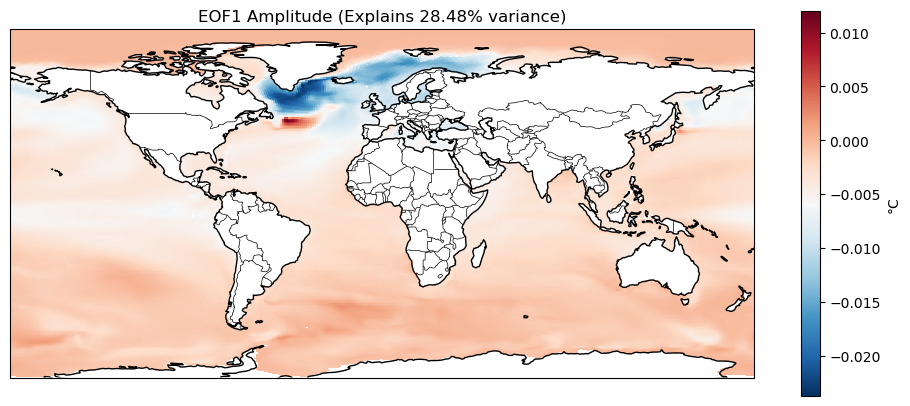

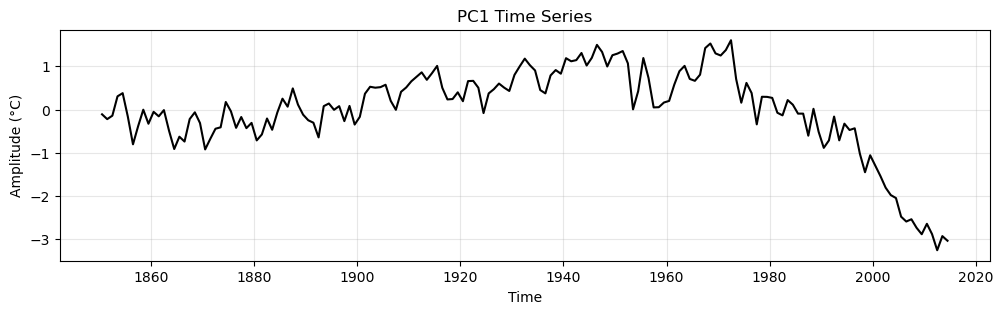

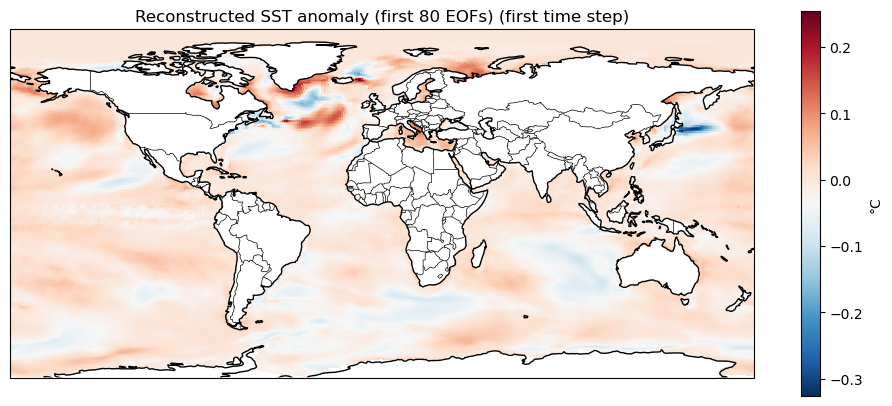

FileNotFoundError: [Errno 2] No such file or directory: "/mnt/c/Users/freja/OneDrive - Aarhus universitet/Documents/Geoscience/Specialeprojekt/Figurer/EOF's/EOF1_Amplitude.png"

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -----------------------------
# 1. EOF1 spatial map (amplitude)
# -----------------------------
fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.PlateCarree())

# 2D lat/lon
lon = thetao_anom['longitude']
lat = thetao_anom['latitude']

EOF1 = eofs_amp[0]  # amplitude map of EOF1

c = ax.pcolormesh(lon, lat, EOF1, cmap='RdBu_r', shading='auto')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title(f"EOF1 Amplitude (Explains {variance_fractions.values[0]:.2f}% variance)")

cb = plt.colorbar(c, ax=ax, orientation='vertical', label='°C')
plt.show()

# -----------------------------
# 2. PC1 time series
# -----------------------------
plt.figure(figsize=(12,3))
plt.plot(thetao_anom['time'], pcs[:,0], color='k')
plt.title("PC1 Time Series")
plt.xlabel("Time")
plt.ylabel("Amplitude (°C)")
plt.grid(True, alpha=0.3)
plt.show()

# -----------------------------
# 3. Reconstructed SST anomaly (first time step)
# -----------------------------
snapshot = reconstruction[0]  # first time step

fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.PlateCarree())

c = ax.pcolormesh(lon, lat, snapshot, cmap='RdBu_r', shading='auto')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title(f"Reconstructed SST anomaly (first {neofs} EOFs) (first time step)")

cb = plt.colorbar(c, ax=ax, orientation='vertical', label='°C')
plt.show()

# save figures to folder
fig.savefig("EOF1_Amplitude.png", dpi=300)
fig.savefig("PC1_TimeSeries.png", dpi=300)
fig.savefig("EOF1_PC1_Reconstruction.png", dpi=300)


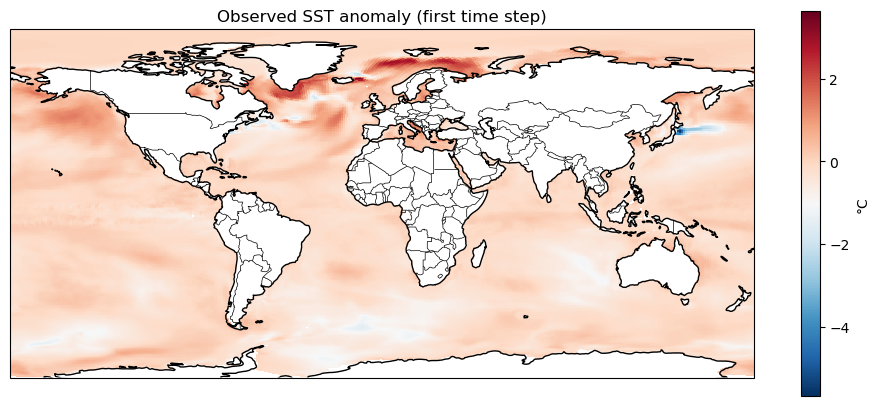

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -----------------------------
# Plot observed SST anomaly (first time step)
# -----------------------------
snapshot_obs = thetao_anom.isel(time=0)  # first time step

fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.PlateCarree())

lon = thetao_anom['longitude']
lat = thetao_anom['latitude']

c = ax.pcolormesh(lon, lat, snapshot_obs, cmap='RdBu_r', shading='auto')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title("Observed SST anomaly (first time step)")

cb = plt.colorbar(c, ax=ax, orientation='vertical', label='°C')
plt.show()


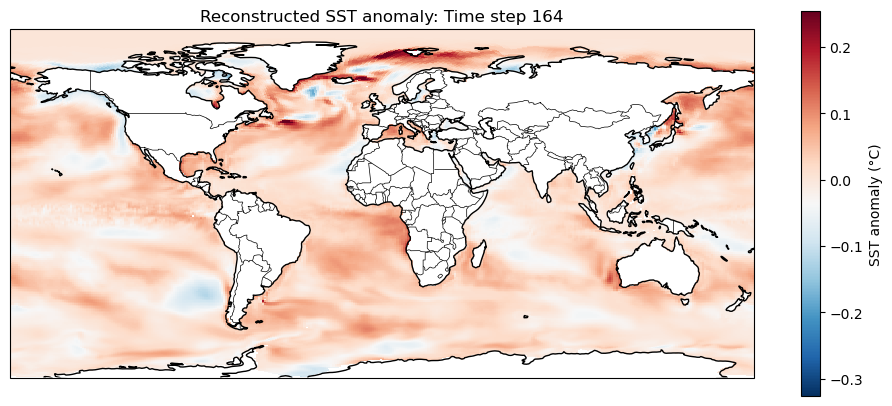

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -----------------------------
# 1. Prepare figure
# -----------------------------
fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

lon = thetao_anom['longitude']
lat = thetao_anom['latitude']

# Initialize pcolormesh with the first time step
cmap = 'RdBu_r'
shading = 'auto'
mesh = ax.pcolormesh(lon, lat, reconstruction[0], cmap=cmap, shading=shading)
cb = plt.colorbar(mesh, ax=ax, orientation='vertical', label='SST anomaly (°C)')
title = ax.set_title(f"Reconstructed SST anomaly: Time step 0")

# -----------------------------
# 2. Update function for animation
# -----------------------------
def update(frame):
    mesh.set_array(reconstruction[frame].ravel())
    title.set_text(f"Reconstructed SST anomaly: Time step {frame}")
    return mesh, title

# -----------------------------
# 3. Create animation
# -----------------------------
nframes = reconstruction.shape[0]  # total number of time steps
anim = FuncAnimation(fig, update, frames=nframes, blit=False)

# -----------------------------
# 4. Save animation (optional)
# -----------------------------

anim.save(os.path.join(downloads_path, 'reconstructed_sst.mp4'), writer='ffmpeg', fps=5)

plt.show()


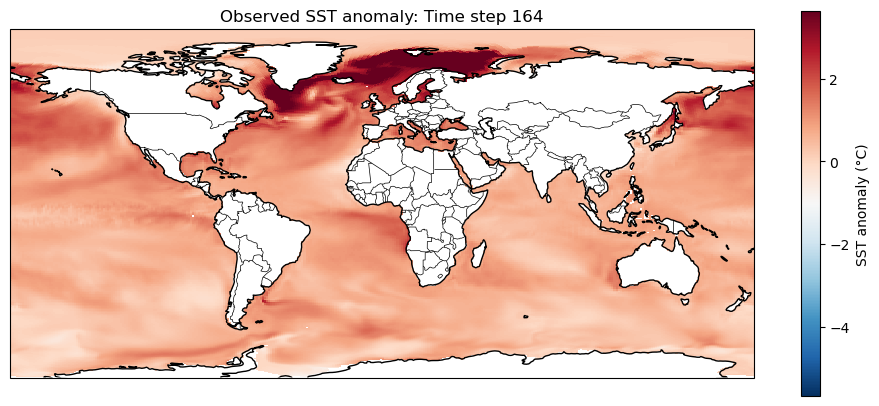

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -----------------------------
# 1. Prepare figure
# -----------------------------
fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

lon = thetao_anom['longitude']
lat = thetao_anom['latitude']

# Initialize pcolormesh with the first time step
cmap = 'RdBu_r'
shading = 'auto'
mesh = ax.pcolormesh(lon, lat, thetao_anom.isel(time=0), cmap=cmap, shading=shading)
cb = plt.colorbar(mesh, ax=ax, orientation='vertical', label='SST anomaly (°C)')
title = ax.set_title(f"Observed SST anomaly: Time step 0")

# -----------------------------
# 2. Update function for animation
# -----------------------------
def update(frame):
    mesh.set_array(thetao_anom.isel(time=frame).values.ravel())
    title.set_text(f"Observed SST anomaly: Time step {frame}")
    return mesh, title

# -----------------------------
# 3. Create animation
# -----------------------------
nframes = thetao_anom.sizes['time']  # total number of time steps
anim = FuncAnimation(fig, update, frames=nframes, blit=False)

# -----------------------------
# 4. Save animation (optional)
# -----------------------------
anim.save(os.path.join(downloads_path, 'observed_sst.mp4'), writer='ffmpeg', fps=5)

plt.show()


In [35]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ----------------------------------------
# 1. Compute correlation map
# ----------------------------------------
# Ensure reconstruction is an xarray.DataArray
reconstruction_da = xr.DataArray(
    reconstruction,
    dims=('time', 'j', 'i'),
    coords={
        'time': thetao_anom['time'],
        'latitude': (('j', 'i'), thetao_anom['latitude'].data),
        'longitude': (('j', 'i'), thetao_anom['longitude'].data)
    },
    name='reconstructed_sst'
)

# Align the DataArrays to ensure they have matching dimensions and coordinates
reconstruction_da_aligned, thetao_anom_aligned = xr.align(reconstruction_da, thetao_anom)

# Compute correlation map
corr_map = xr.apply_ufunc(
    np.corrcoef,
    reconstruction_da_aligned.stack(grid=('j', 'i')),
    thetao_anom_aligned.stack(grid=('j', 'i')),
    input_core_dims=[['time'], ['time']],
    output_core_dims=[['grid', 'grid']],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
).isel(grid=0).unstack('grid')

# ----------------------------------------
# 2. Compute global mean time series
# ----------------------------------------
weights = np.cos(np.deg2rad(thetao_anom['latitude']))
weights = weights / weights.mean()  # normalize weights

obs_global = (thetao_anom * weights).mean(dim=['j','i'])
recon_global = (reconstruction * weights).mean(dim=['j','i'])

# ----------------------------------------
# 3. Start figure layout
# ----------------------------------------
fig = plt.figure(figsize=(16, 10))

# ===== (A) Spatial correlation map =====
ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
lon = thetao_anom['longitude']
lat = thetao_anom['latitude']
mesh = ax1.pcolormesh(lon, lat, corr_map, cmap='RdBu_r', vmin=-1, vmax=1, shading='auto')
ax1.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax1.add_feature(cfeature.BORDERS, linewidth=0.3)
ax1.set_title("A) Spatial Correlation: Reconstructed vs Observed", fontsize=12)
plt.colorbar(mesh, ax=ax1, orientation='horizontal', pad=0.05, label='Correlation')

# ===== (B) Time series comparison =====
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(thetao_anom['time'], obs_global, label='Observed SST anomaly', color='k', linewidth=1.5)
ax2.plot(thetao_anom['time'], recon_global, label='Reconstructed SST (EOF1)', color='crimson', alpha=0.8, linewidth=1.5)
ax2.set_title("B) Global Mean SST Anomaly: Observed vs Reconstructed", fontsize=12)
ax2.set_xlabel("Time")
ax2.set_ylabel("SST anomaly (°C)")
ax2.legend()
ax2.grid(alpha=0.3)

# ===== (C) Scatter comparison =====
ax3 = fig.add_subplot(2, 2, 2)
ax3.scatter(obs_global, recon_global, alpha=0.5, color='teal', edgecolor='none')
ax3.axline((0, 0), slope=1, color='r', linestyle='--', linewidth=1)
ax3.set_xlabel("Observed SST anomaly (°C)")
ax3.set_ylabel("Reconstructed SST anomaly (°C)")
ax3.set_title("C) Observed vs Reconstructed SST anomalies", fontsize=12)
ax3.grid(alpha=0.3)

# Adjust layout for clarity
plt.tight_layout()
plt.show()



ValueError: operand to apply_ufunc encountered unexpected dimensions ['grid'] on an input variable: these are core dimensions on other input or output variables